<br/>

$$ \huge{\underline{\textbf{ Continuous Actions }}} $$

<br/>

<center>Implementation of <b>Policy for Continuous Actions</b> equations</center>
<center>from Sutton and Barto 2018, <b>chapter 13.7</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

Relevant equations from the book:

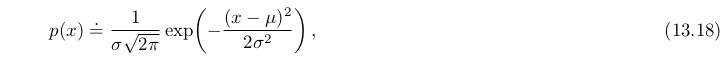

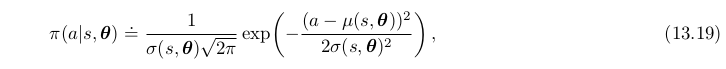

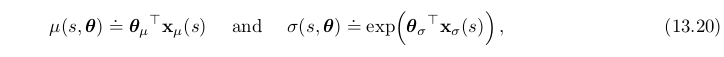

Equations from Exercise 13.4:

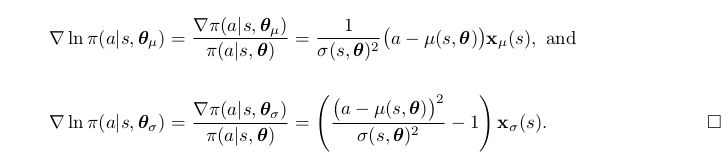

# Experiment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gaussian(x, mean, std):
    """Gaussian probability density function. Book eq. 13.18"""
    var = np.power(std, 2)
    denom = (2*np.pi*var)**.5
    num = np.exp( -np.power(x-mean,2) / (2*var) )
    return num / denom

In [3]:
class ContinuousBanditEnv:
    def __init__(self, means):
        self.means = means
        self.std = np.ones_like(means)
    def step(self, action):
        assert action.shape == self.means.shape
        rewards = gaussian(x=action, mean=self.means, std=self.std)
        return np.sum(rewards)

# Policy Definition

In [4]:
class TabularGaussinaPolicy:
    """Tabular action-state function 'approximator'"""
    def __init__(self, lr, nb_states, nb_actions, l2=0.0, ent=0.0):
        assert isinstance(lr, float)
        assert isinstance(nb_states, tuple)
        assert isinstance(nb_actions, int)
        self._lr = lr                # learning rate
        self._l2 = l2                # L2 reg.
        self._ent = ent              # entropy reg.
        self.n_act = nb_actions
        self._theta_mu = np.zeros((*nb_states, nb_actions))     # weights
        self._theta_sigma = np.zeros((*nb_states, nb_actions))  # weights
        
    def pi(self, state):
        """Return policy, i.e. probability distribution over actions."""
        assert isinstance(state, (int, tuple))
        assert self._theta_mu.ndim == 2 if isinstance(state, int) else len(state)+1
        assert self._theta_sigma.ndim == 2 if isinstance(state, int) else len(state)+1
        
        # Eq. 13.20
        # in tabular case x(s) vectors are one-hot, which is same as table lookup
        mu = self._theta_mu[state].copy()
        sigma = np.exp(self._theta_sigma[state])
        return mu, sigma         # do not sample here

    def update(self, state, action, disc_return):
        assert isinstance(disc_return, float)
        
        mu = self._theta_mu[state]                               # Eq. 13.20
        sigma = np.exp(self._theta_sigma[state])
        
        grad_ln_theta_mu = (1/sigma**2) * (action-mu)            # Ex. 13.4
        grad_ln_theta_sigma = (((action-mu)**2 / sigma**2) - 1)
        
        # L2 regularization - helps to ensure policy doesn't get deterministic
        grad_ln_theta_mu -= self._l2 * self._theta_mu[state]
        grad_ln_theta_sigma -= self._l2 * self._theta_sigma[state]
        
        # entropy reg. - also helps to ensure policy doesn't get deterministic
        prob = gaussian(action, mu, sigma)
        entropy = -1 * np.sum(prob * np.log(prob))
        grad_ln_theta_mu -= self._ent * entropy
        grad_ln_theta_sigma -= self._ent * entropy
        
        # apply update
        self._theta_mu[state] += self._lr * grad_ln_theta_mu * disc_return
        self._theta_sigma[state] += self._lr * grad_ln_theta_sigma * disc_return

def test_tgp():
    tgp = TabularGaussinaPolicy(lr=0.01, l2=0.0, nb_states=(2,), nb_actions=1)
    tgp.update(1, 5.0, 1.0)
    mu, sigma = tgp.pi(state=0)
    assert np.alltrue(mu == 0.0)
    assert np.alltrue(sigma == 1.0)
    mu, sigma = tgp.pi(state=1)
    assert np.alltrue(mu == 0.05)
    assert np.allclose(sigma, 1.271249)

    print('PASS')
test_tgp()

PASS


# Examples

### Basic Example

In [5]:
env = ContinuousBanditEnv(means=np.array([2.0]))

In [6]:
tgp = TabularGaussinaPolicy(lr=0.01, nb_states=(1,), nb_actions=1, l2=0.0, ent=0.0)

hist_R, hist_mu, hist_sigma = [], [], []
for i in range(10000):
    mu, sigma = tgp.pi(state=0)
    action = np.random.normal(loc=mu, scale=sigma)
    
    reward = env.step(action)
    
    tgp.update(state=0, action=action, disc_return=reward)
    
    mu, sigma = tgp.pi(state=0)
    hist_R.append(reward)
    hist_mu.append(mu)
    hist_sigma.append(sigma)

hist_R = np.array(hist_R)
hist_mu = np.array(hist_mu)
hist_sigma = np.array(hist_sigma)

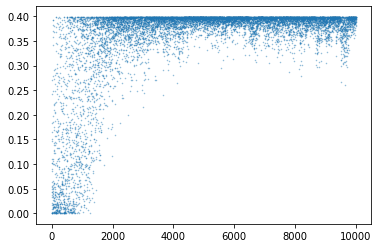

In [7]:
plt.scatter(range(len(hist_R)), hist_R, marker='.', s=1, alpha=0.5)
plt.show()

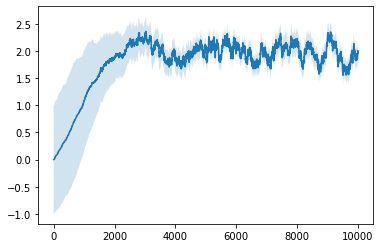

In [8]:
plt.plot(hist_mu[:,0])
plt.fill_between(range(len(hist_mu)),
                 hist_mu[:,0]-hist_sigma[:,0],
                 hist_mu[:,0]+hist_sigma[:,0],
                 alpha=0.2)

### Example - With Regularization

In [9]:
env = ContinuousBanditEnv(means=np.array([2.0]))

In [10]:
tgp = TabularGaussinaPolicy(lr=0.01, nb_states=(1,), nb_actions=1, l2=0.0, ent=0.1)

hist_R, hist_mu, hist_sigma = [], [], []
for i in range(10000):
    mu, sigma = tgp.pi(state=0)
    action = np.random.normal(loc=mu, scale=sigma)
    
    reward = env.step(action)
    
    tgp.update(state=0, action=action, disc_return=reward)
    
    mu, sigma = tgp.pi(state=0)
    hist_R.append(reward)
    hist_mu.append(mu)
    hist_sigma.append(sigma)

hist_R = np.array(hist_R)
hist_mu = np.array(hist_mu)
hist_sigma = np.array(hist_sigma)

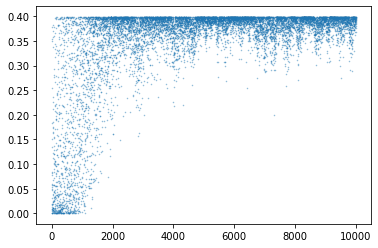

In [11]:
plt.scatter(range(len(hist_R)), hist_R, marker='.', s=1, alpha=0.5)
plt.show()

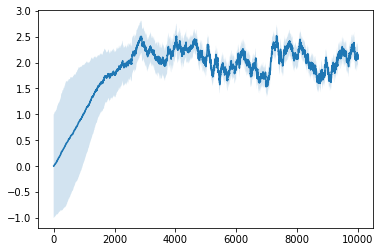

In [12]:
plt.plot(hist_mu[:,0])
plt.fill_between(range(len(hist_mu)),
                 hist_mu[:,0]-hist_sigma[:,0],
                 hist_mu[:,0]+hist_sigma[:,0],
                 alpha=0.2)

### Example - 2D Actions

In [13]:
env = ContinuousBanditEnv(means=np.array([2.0, -2.0]))

In [14]:
tgp = TabularGaussinaPolicy(lr=0.005, nb_states=(1,), nb_actions=2, l2=0.0, ent=0.1)

hist_R, hist_mu, hist_sigma = [], [], []
for i in range(10000):
    mu, sigma = tgp.pi(state=0)
    action = np.random.normal(loc=mu, scale=sigma)
    
    reward = env.step(action)
    
    tgp.update(state=0, action=action, disc_return=reward)
    
    mu, sigma = tgp.pi(state=0)
    hist_R.append(reward)
    hist_mu.append(mu)
    hist_sigma.append(sigma)

hist_R = np.array(hist_R)
hist_mu = np.array(hist_mu)
hist_sigma = np.array(hist_sigma)

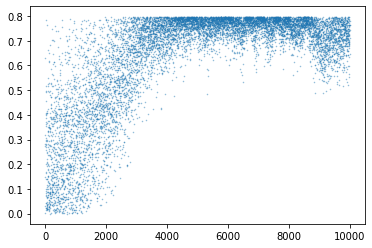

In [15]:
plt.scatter(range(len(hist_R)), hist_R, marker='.', s=1, alpha=0.5)
plt.show()

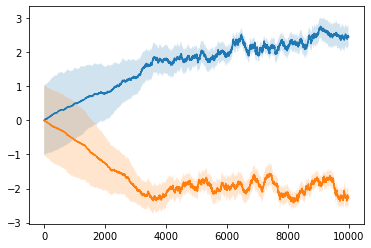

In [16]:
plt.plot(hist_mu[:,0])
plt.fill_between(range(len(hist_mu)),
                 hist_mu[:,0]-hist_sigma[:,0],
                 hist_mu[:,0]+hist_sigma[:,0],
                 alpha=0.2)
plt.plot(hist_mu[:,1])
plt.fill_between(range(len(hist_mu)),
                 hist_mu[:,1]-hist_sigma[:,1],
                 hist_mu[:,1]+hist_sigma[:,1],
                 alpha=0.2)

# Debug and Development

# Basic Implementation - NumPy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Helpers

In [2]:
def gaussian(x, mean, std):
    var = std**2
    denom = (2*np.pi*var)**.5
    num = np.exp( -(x-mean)**2 / (2*var) )
    return num / denom

In [3]:
def pi(theta_mu, theta_sigma):
    return np.random.normal(loc=theta_mu, scale=np.exp(theta_sigma))

In [4]:
def x_mu(state):
    return 1.0

In [5]:
def x_sigma(state):
    return 1.0

In [6]:
def grad_ln_theta_mu(state, action, theta_mu, theta_sigma):
    mu, sigma = theta_mu, np.exp(theta_sigma)
    return (1 / sigma**2) * (action - mu) * x_mu(state)  # Ex. 13.4

In [7]:
def grad_ln_theta_sigma(state, action, theta_mu, theta_sigma):
    mu, sigma = theta_mu, np.exp(theta_sigma)
    return (((action - mu)**2 / sigma**2) - 1) * x_sigma(state)

### Show gradients

In [8]:
theta_mu = 0.0
theta_sigma = 0.0

In [9]:
grad_ln_theta_mu(None, 5.0, theta_mu, theta_sigma)

5.0

In [10]:
grad_ln_theta_sigma(None, 5.0, theta_mu, theta_sigma)

24.0

In [11]:
aa = np.linspace(-3, 3)
mm = grad_ln_theta_mu(None, aa, theta_mu, theta_sigma)
ss = grad_ln_theta_sigma(None, aa, theta_mu, theta_sigma)

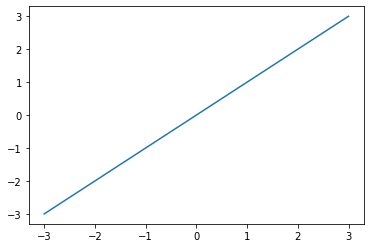

In [12]:
plt.plot(aa, mm)

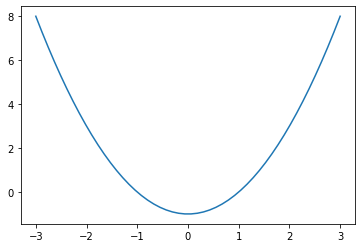

In [13]:
plt.plot(aa, ss)

### Plotting

In [14]:
def print_plot(theta_mu, theta_sigma):
    mu, sigma = theta_mu, np.exp(theta_sigma)
    
    print('mu:', mu)
    print('sigma:', sigma)
        
    res = []
    for i in range(100000):
        res.append(pi(theta_mu, theta_sigma))
    plt.hist(res, bins=100, density=True)

    X = np.linspace(-10, 10)
    Y = gaussian(X, mean=0.0, std=1.0)
    plt.plot(X, Y)
    Y = gaussian(X, mean=mu, std=sigma)
    plt.plot(X, Y, color='red')

    plt.show()

mu: 0.0
sigma: 1.0


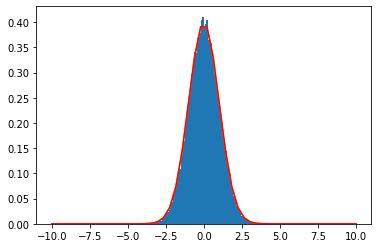

In [15]:
print_plot(theta_mu, theta_sigma)

### Step-by-Step

In [16]:
theta_mu = 0.0
theta_sigma = 0.0

In [17]:
lr = 0.01

In [18]:
grad_theta_mu = grad_ln_theta_mu(None, 5.0, theta_mu, theta_sigma)
grad_theta_sigma = grad_ln_theta_sigma(None, 5.0, theta_mu, theta_sigma)

In [19]:
print(theta_mu, grad_theta_mu)
print(theta_sigma, grad_theta_sigma)

0.0 5.0
0.0 24.0


In [20]:
theta_mu += lr * grad_theta_mu
theta_sigma += lr * grad_theta_sigma

mu: 0.05
sigma: 1.2712491503214047


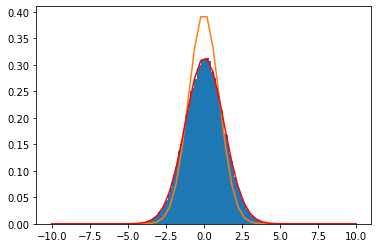

In [21]:
print_plot(theta_mu, theta_sigma)

### 1000 Steps

In [22]:
lr = 0.01
theta_mu = 0.0
theta_sigma = 0.0

In [23]:
res_theta_mu = []
res_grad_theta_mu = []
res_theta_sigma = []
res_grad_theta_sigma = []
res_sigma = []

In [24]:
for i in range(2000):
    grad_theta_mu = grad_ln_theta_mu(None, 5.0, theta_mu, theta_sigma)
    grad_theta_sigma = grad_ln_theta_sigma(None, 5.0, theta_mu, theta_sigma)
    
    theta_mu += lr * grad_theta_mu
    theta_sigma += lr * grad_theta_sigma
    
    res_theta_mu.append(theta_mu)
    res_grad_theta_mu.append(grad_theta_mu)
    res_theta_sigma.append(theta_sigma)
    res_grad_theta_sigma.append(grad_theta_sigma)
    res_sigma.append(np.exp(theta_sigma))

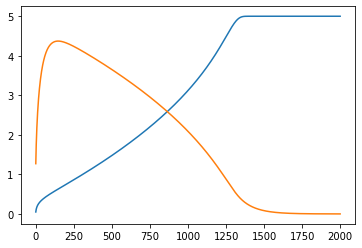

In [25]:
plt.plot(res_theta_mu)
plt.plot(res_sigma)

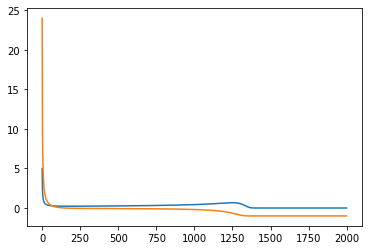

In [26]:
plt.plot(res_grad_theta_mu)
plt.plot(res_grad_theta_sigma)

# Basic Implementation - PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

### Helpers

In [2]:
def gaussian_t(x_t, mean_t, std_t):
    var_t = std_t**2
    denom_t = (2*np.pi*var_t)**.5
    num_t = torch.exp( -(x_t-mean_t)**2 / (2*var_t) )
    return num_t / denom_t

In [3]:
def pi_t(state, mu_t, sigma_t, do_exp):
    with torch.no_grad():
        std_t = torch.exp(sigma_t) if do_exp else sigma_t
        #return np.random.normal(loc=theta_mu, scale=theta_sigma)
        return torch.normal(mu_t, std_t).item()

### Show gradients

In [4]:
_theta_mu_t = torch.tensor([0.0], requires_grad=True)
_theta_sigma_t = torch.tensor([0.0], requires_grad=True)

In [5]:
X = np.linspace(-3, 3)
grad_X = []
grad_Y = []
for a in X:
    std_t = torch.exp(_theta_sigma_t)
    prob_t = gaussian_t(a, _theta_mu_t, std_t)
    log_t = torch.log(prob_t)
    loss = log_t
    loss.backward()
    
    grad_X.append(_theta_mu_t.grad.data.item())
    _theta_mu_t.grad.data.zero_()
    grad_Y.append(_theta_sigma_t.grad.data.item())
    _theta_sigma_t.grad.data.zero_()

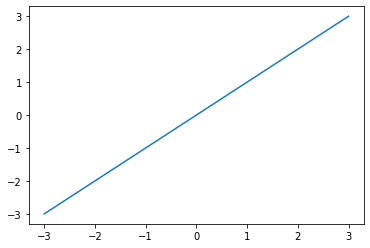

In [6]:
plt.plot(X, grad_X)

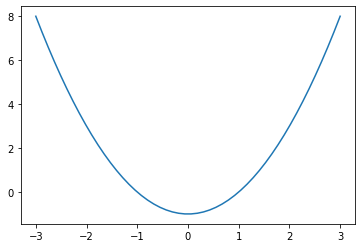

In [7]:
plt.plot(X, grad_Y)

### Plotting

In [8]:
# _dist = torch.distributions.Normal(_theta_mu_t, _theta_sigma_t)

In [9]:
def print_plot(mu_t, sigma_t, do_exp):
    
    with torch.no_grad():
        
        
        
        print('mu_t:', mu_t, mu_t.grad)
        print('sigma_t:', sigma_t, sigma_t.grad)
        
        std_t = torch.exp(sigma_t) if do_exp else sigma_t
            
        print('std_t:', std_t, std_t.grad)
        
        res = []
        for i in range(100000):
            res.append(pi_t(0, mu_t, sigma_t, do_exp))
        plt.hist(res, bins=100, density=True)
        
        X_t = torch.linspace(-10, 10, dtype=float)
        Y_t = gaussian_t(X_t, mean_t=0.0, std_t=1.0)
        plt.plot(X_t.numpy(), Y_t.numpy())
        Y_t = gaussian_t(X_t, mean_t=mu_t, std_t=std_t)
        plt.plot(X_t.numpy(), Y_t.numpy(), color='red')
        
    plt.show()

In [10]:
_theta_mu_t = torch.tensor([0.0], dtype=float, requires_grad=True)
_theta_sigma_t = torch.tensor([1.0], dtype=float, requires_grad=True)

mu_t: tensor([0.], dtype=torch.float64, requires_grad=True) None
sigma_t: tensor([1.], dtype=torch.float64, requires_grad=True) None
std_t: tensor([1.], dtype=torch.float64, requires_grad=True) None


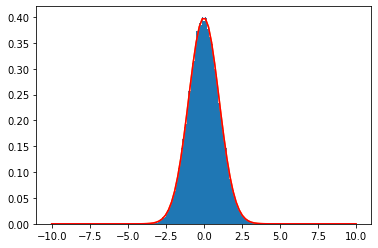

In [11]:
print_plot(_theta_mu_t, _theta_sigma_t, do_exp=False)

### Step-by-Step

In [12]:
do_exp = True

In [13]:
_theta_mu_t = torch.tensor([0.0], dtype=float, requires_grad=True)
_theta_sigma_t = torch.tensor([0.0], dtype=float, requires_grad=True)

In [14]:
lr = 0.01

In [15]:
std_t = torch.exp(_theta_sigma_t) if do_exp else _theta_sigma_t
std_t

tensor([1.], dtype=torch.float64, grad_fn=<ExpBackward>)

In [16]:
prob_t = gaussian_t(5.0, _theta_mu_t, std_t)
print(prob_t)
print(prob_t.grad)

tensor([1.4867e-06], dtype=torch.float64, grad_fn=<DivBackward0>)
None


In [17]:
log_t = torch.log(prob_t)
print(log_t)
print(log_t.grad)

tensor([-13.4189], dtype=torch.float64, grad_fn=<LogBackward>)
None


In [18]:
loss = log_t
loss.backward()

In [19]:
print(log_t)
print(log_t.grad)

tensor([-13.4189], dtype=torch.float64, grad_fn=<LogBackward>)
None


In [20]:
print(_theta_mu_t)
print(_theta_mu_t.grad)

tensor([0.], dtype=torch.float64, requires_grad=True)
tensor([5.], dtype=torch.float64)


In [21]:
print(_theta_sigma_t)
print(_theta_sigma_t.grad)

tensor([0.], dtype=torch.float64, requires_grad=True)
tensor([24.], dtype=torch.float64)


In [22]:
_theta_mu_t.data.add_(lr * _theta_mu_t.grad.data)
_theta_sigma_t.data.add_(lr * _theta_sigma_t.grad.data)
_theta_mu_t.grad.data.zero_()
_theta_sigma_t.grad.data.zero_()

tensor([0.], dtype=torch.float64)

mu_t: tensor([0.0500], dtype=torch.float64, requires_grad=True) tensor([0.], dtype=torch.float64)
sigma_t: tensor([0.2400], dtype=torch.float64, requires_grad=True) tensor([0.], dtype=torch.float64)
std_t: tensor([1.2712], dtype=torch.float64) None


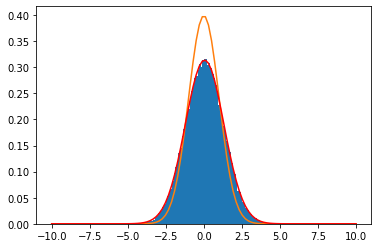

In [23]:
print_plot(_theta_mu_t, _theta_sigma_t, do_exp)

### 1000 Steps

In [24]:
lr = 0.01

In [25]:
_theta_mu_t = torch.tensor([0.0], dtype=float, requires_grad=True)
_theta_sigma_t = torch.tensor([0.0], dtype=float, requires_grad=True)

In [26]:
res_theta_mu = []
res_grad_theta_mu = []
res_theta_sigma = []
res_grad_theta_sigma = []
res_sigma = []

In [27]:
for i in range(2000):
    std_t = torch.exp(_theta_sigma_t)
    prob_t = gaussian_t(5.0, _theta_mu_t, std_t)
    log_t = torch.log(prob_t)
    loss = log_t
    loss.backward()
        
    i_grad_theta_mu = _theta_mu_t.grad.data.item()
    i_grad_theta_sigma = _theta_sigma_t.grad.data.item()
    
    _theta_mu_t.data.add_(lr * _theta_mu_t.grad.data)
    _theta_sigma_t.data.add_(lr * _theta_sigma_t.grad.data)
    _theta_mu_t.grad.data.zero_()
    _theta_sigma_t.grad.data.zero_()
    
    with torch.no_grad():
        i_theta_mu = _theta_mu_t.item()
        i_theta_sigma = _theta_sigma_t.item()
        i_sigma = torch.exp(_theta_sigma_t).item()
    
    res_theta_mu.append(i_theta_mu)
    res_grad_theta_mu.append(i_grad_theta_mu)
    res_theta_sigma.append(i_theta_sigma)
    res_grad_theta_sigma.append(i_grad_theta_sigma)
    res_sigma.append(i_sigma)
    

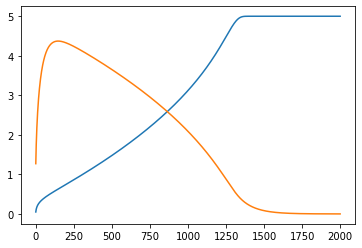

In [28]:
plt.plot(res_theta_mu)
plt.plot(res_sigma)

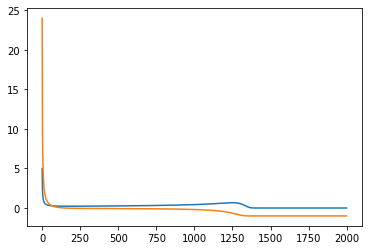

In [29]:
plt.plot(res_grad_theta_mu)
plt.plot(res_grad_theta_sigma)